In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class AdaptiveGatedAttention(nn.Module):
    def __init__(self, orig_attn):
        super().__init__()
        self.qkv = orig_attn.qkv
        self.proj = orig_attn.proj
        self.num_heads = orig_attn.num_heads
        self.head_dim = orig_attn.head_dim
        self.scale = orig_attn.scale

        self.gate_net = nn.Sequential(
            nn.Linear(orig_attn.embed_dim, orig_attn.embed_dim // 4),
            nn.ReLU(),
            nn.Linear(orig_attn.embed_dim // 4, self.num_heads),
            nn.Sigmoid()
        )

    def forward(self, x):
        B, N, C = x.shape
        gates = self.gate_net(x.mean(dim=1)).unsqueeze(-1).unsqueeze(-1)  # (B, H, 1, 1)

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)

        gated_attn = attn * gates
        gated_attn = gated_attn / gated_attn.sum(dim=-1, keepdim=True)

        out = (gated_attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(out)



class AdversarialDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.detector = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x_cls_token):
        return self.detector(x_cls_token).squeeze(-1)  # Output shape: (B,)


class AttentionDiagnosisHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # 0 = shifting, 1 = attenuation
        )

    def forward(self, x_cls_token):
        return self.classifier(x_cls_token)


class ViTAdversarialDefense(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.vit = base_model
        self.detector = AdversarialDetector(input_dim=768)
        self.diagnoser = AttentionDiagnosisHead(input_dim=768)

        self.original_blocks = [block.attn for block in self.vit.blocks]

    def forward(self, x):
        B = x.size(0)
        x = self.vit.patch_embed(x)
        cls_token = self.vit.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = self.vit.pos_drop(x + self.vit.pos_embed)

        for i, block in enumerate(self.vit.blocks):
            x = block(x)
            if i == 5:
                is_adv = self.detector(x[:, 0]) > 0.5
                if is_adv.any():
                    diag = self.diagnoser(x[:, 0]).argmax(dim=1)  # 0 or 1
                    for j in range(i+1, len(self.vit.blocks)):
                        if diag[0] == 0:
                            self.vit.blocks[j].attn = AdaptiveGatedAttention(self.original_blocks[j])
                        elif diag[0] == 1:
                            self.vit.blocks[j].attn = AdaptiveGatedAttention(self.original_blocks[j])
                    break

        x = self.vit.norm(x)
        return self.vit.head(x[:, 0])

### Train classifier + diagnoser

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import torch.nn.functional as F
from tqdm import tqdm

class AdversarialDataset(Dataset):
    def __init__(self, metadata_csv, clean_root, transform=None):
        self.metadata = pd.read_csv(metadata_csv)
        self.clean_root = clean_root
        self.transform = transform

        self.clean_paths = {}
        for _, row in self.metadata.iterrows():
            class_name = row['original_class']
            adv_filename = os.path.basename(row['image_path'])
            original_filename = adv_filename.replace(f"{class_name}_", "")
            clean_path = os.path.join(clean_root, class_name, original_filename)
            self.clean_paths[row['image_path']] = clean_path

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        image_path = row['image_path']
        attack_type = row['attack_type']
        try:
            image = Image.open(image_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except:
            image = torch.zeros(3, 224, 224)
        class_name = row['original_class']
        return image, 1, attack_type, class_name


class DiagnoserTrainer:
    def __init__(self, base_vit_model, device='cuda'):
        self.base_vit = base_vit_model
        self.device = device
        self.diagnoser = AttentionDiagnosisHead(input_dim=768).to(device)
        self.diagnoser_optimizer = optim.Adam(self.diagnoser.parameters(), lr=1e-3)
        self.diagnosis_loss = nn.CrossEntropyLoss()

        self.attention_patterns = []
        self.attack_types = []

    def extract_cls_features(self, images):
        self.base_vit.eval()
        with torch.no_grad():
            tokens = self.base_vit.forward_features(images)
            return tokens[:, 0]

    def extract_attention_patterns(self, images):
        self.base_vit.eval()

        def save_attn_hook(module, input, output):
            self._last_attn = output

        handle = self.base_vit.blocks[5].attn.register_forward_hook(save_attn_hook)
        with torch.no_grad():
            _ = self.base_vit(images)
            attn = self._last_attn
            if attn.dim() == 4:
                cls_attn = attn[:, :, 0, 1:].mean(dim=1)
            elif attn.dim() == 3:
                cls_attn = attn[:, 0, 1:]
            else:
                raise ValueError(f"Unexpected attention shape: {attn.shape}")
        handle.remove()
        return cls_attn

    def collect_attention_patterns(self, dataloader, max_samples=2000):
        self.attention_patterns = []
        self.attack_types = []

        sample_count = 0
        for images, _, attack_types_batch, _ in tqdm(dataloader, desc="Collecting attention"):
            if sample_count >= max_samples:
                break
            images = images.to(self.device)
            patterns = self.extract_attention_patterns(images)
            self.attention_patterns.extend(patterns.cpu().numpy())
            self.attack_types.extend(attack_types_batch)
            sample_count += len(images)

        self.attention_patterns = np.array(self.attention_patterns)
        print(f"Collected {len(self.attention_patterns)} attention patterns")

    def discover_attack_clusters(self, n_clusters=3):
        print("Clustering Attention Patterns")
        patterns = np.array(self.attention_patterns)

        from sklearn.decomposition import PCA
        pca = PCA(n_components=min(50, patterns.shape[1]))
        patterns_pca = pca.fit_transform(patterns)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(patterns_pca)

        attack_types = np.array(self.attack_types)
        for i in range(n_clusters):
            mask = cluster_labels == i
            print(f"\nCluster {i} ({np.sum(mask)} samples):")
            unique, counts = np.unique(attack_types[mask], return_counts=True)
            for u, c in zip(unique, counts):
                print(f"  {u}: {c}")

        return cluster_labels

    def create_diagnosis_labels(self, cluster_labels):
        cluster_to_diagnosis = {
            0: 0,
            1: 1,
            2: 0
        }
        return np.array([cluster_to_diagnosis.get(c, 0) for c in cluster_labels])

    def train_diagnoser(self, dataloader, diagnosis_labels, num_epochs=10, save_dir="checkpoints"):
        os.makedirs(save_dir, exist_ok=True)
        self.diagnoser.train()
        pattern_to_diagnosis = {i: diagnosis_labels[i] for i in range(len(diagnosis_labels))}

        for epoch in range(num_epochs):
            total_loss, correct, total = 0, 0, 0
            global_sample_idx = 0  # reset each epoch

            for images, _, _, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
                images = images.to(self.device)
                cls_features = self.extract_cls_features(images)

                batch_labels = []
                for _ in range(images.size(0)):
                    label = pattern_to_diagnosis.get(global_sample_idx)
                    global_sample_idx += 1
                    if label is not None:
                        batch_labels.append(label)

                if not batch_labels:
                    continue

                labels_tensor = torch.tensor(batch_labels).to(self.device)
                self.diagnoser_optimizer.zero_grad()
                preds = self.diagnoser(cls_features[:len(batch_labels)])
                loss = self.diagnosis_loss(preds, labels_tensor)
                loss.backward()
                self.diagnoser_optimizer.step()

                total_loss += loss.item()
                _, predicted = preds.max(1)
                correct += predicted.eq(labels_tensor).sum().item()
                total += labels_tensor.size(0)

            if total > 0:
                print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}, Accuracy = {100. * correct / total:.2f}%")
            else:
                print(f"Epoch {epoch+1}: No valid training samples.")
            torch.save(self.diagnoser.state_dict(), os.path.join(save_dir, f"diagnoser_epoch_{epoch+1}.pt"))

    def evaluate(self, dataloader, diagnosis_labels):
        self.diagnoser.eval()
        correct, total = 0, 0
        idx = 0

        with torch.no_grad():
            for images, _, _, _ in tqdm(dataloader, desc="Evaluating"):
                if idx >= len(diagnosis_labels):
                    break  # Stop once we’ve exhausted the labels

                images = images.to(self.device)
                cls_features = self.extract_cls_features(images)
                preds = self.diagnoser(cls_features)
                _, predicted = preds.max(1)

                batch_size = images.size(0)
                label_slice = diagnosis_labels[idx:min(idx + batch_size, len(diagnosis_labels))]
                true = torch.tensor(label_slice).to(self.device)

                predicted = predicted[:true.size(0)]  # Crop if needed

                correct += predicted.eq(true).sum().item()
                total += true.size(0)
                idx += true.size(0)

        print(f"Diagnoser Accuracy: {100. * correct / total:.2f}%")



In [ ]:
def train_diagnoser_pipeline(base_vit_model, metadata_csv, clean_root, transform):
    dataset = AdversarialDataset(metadata_csv, clean_root, transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    trainer = DiagnoserTrainer(base_vit_model)

    trainer.collect_attention_patterns(dataloader, max_samples=2000)
    cluster_labels = trainer.discover_attack_clusters(n_clusters=3)
    diagnosis_labels = trainer.create_diagnosis_labels(cluster_labels)

    trainer.train_diagnoser(dataloader, diagnosis_labels, num_epochs=10)
    trainer.evaluate(dataloader, diagnosis_labels)

    return trainer


In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
label = torch.tensor([187]).to(device)


In [ ]:
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device).eval()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader

val_csv_path = "/content/drive/MyDrive/my231n/adversarial_val_dataset/metadata_with_clean.csv"
val_df = pd.read_csv(val_csv_path)
val_adv_df = val_df[val_df['attack_type'] != 'clean'].reset_index(drop=True)

val_filtered_path = "/content/drive/MyDrive/my231n/adversarial_val_dataset/metadata_adv_only.csv"
val_adv_df.to_csv(val_filtered_path, index=False)


In [ ]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_dataset = AdversarialDataset(
    metadata_csv=val_filtered_path,
    clean_root="/content/drive/MyDrive/my231n/adversarial_val_dataset/clean",  # won't be used
    transform=transform
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
print(len(val_loader))

375


In [ ]:
import pandas as pd
from torch.utils.data import DataLoader
import torch
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_csv = "/content/drive/MyDrive/my231n/adversarial_train_dataset/metadata_with_clean.csv"
train_df = pd.read_csv(train_csv)
train_adv_df = train_df[train_df['attack_type'] != 'clean'].reset_index(drop=True)
train_adv_csv = "/content/drive/MyDrive/my231n/adversarial_train_dataset/metadata_adv_only.csv"
train_adv_df.to_csv(train_adv_csv, index=False)

train_dataset = AdversarialDataset(train_adv_csv, clean_root="", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_adv_csv = "/content/drive/MyDrive/my231n/adversarial_val_dataset/metadata_adv_only.csv"
val_df = pd.read_csv(val_csv)
val_adv_df = val_df[val_df['attack_type'] != 'clean'].reset_index(drop=True)
val_adv_df.to_csv(val_adv_csv, index=False)

val_dataset = AdversarialDataset(val_adv_csv, clean_root="", transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

trainer = DiagnoserTrainer(base_vit_model=model)

trainer.collect_attention_patterns(train_loader, max_samples = len(train_loader))
pca = PCA(n_components=min(50, trainer.attention_patterns.shape[1]))
train_pca = pca.fit_transform(trainer.attention_patterns)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(train_pca)
diagnosis_labels = trainer.create_diagnosis_labels(train_clusters)

trainer.train_diagnoser(train_loader, diagnosis_labels, num_epochs=5)

trainer.collect_attention_patterns(val_loader, max_samples = len(val_loader))
val_pca = pca.transform(trainer.attention_patterns)
val_clusters = kmeans.predict(val_pca)
val_diagnosis_labels = trainer.create_diagnosis_labels(val_clusters)

trainer.evaluate(val_loader, diagnosis_labels=val_diagnosis_labels)


In [ ]:
import pickle
# After evaluation
with open("diagnoser_utils.pkl", "wb") as f:
    pickle.dump({
        "pca": pca,
        "kmeans": kmeans
    }, f)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# subset adversarial only
trainer = train_detector_diagnoser_pipeline(
    base_vit_model=model,
    metadata_csv=subset_csv_path,
    clean_root=clean_root,
    transform=transform
)


Detector Epoch 1:  72%|███████▏  | 218/304 [53:43<23:43, 16.55s/it]

In [ ]:
!pip install torchattacks

In [ ]:
!pip install torchattacks

In [ ]:
class AttentionDiagnosisHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)  # 0 = shifting, 1 = attenuation
        )

    def forward(self, x_cls_token):
        return self.classifier(x_cls_token)


diagnoser_head = AttentionDiagnosisHead(input_dim=768, hidden_dim=64)
diagnoser_head.load_state_dict(torch.load("/content/checkpoints/diagnoser_epoch_5.pt", map_location='cpu'))
diagnoser_head.eval()


AttentionDiagnosisHead(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Plotting

  3%|▎         | 11/375 [00:26<14:41,  2.42s/it]


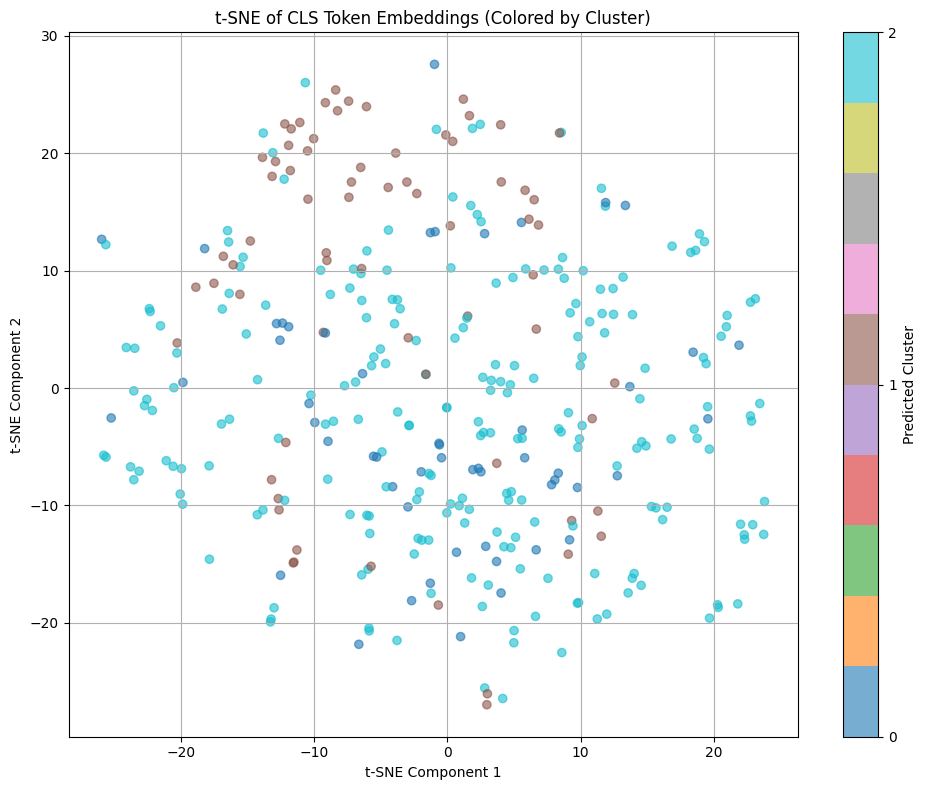

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import numpy as np
from tqdm import tqdm
from timm import create_model

with open("/content/diagnoser_utils.pkl", 'rb') as f:
    diagnoser_utils = pickle.load(f)
    pca = diagnoser_utils['pca']
    kmeans = diagnoser_utils['kmeans']

vit = create_model('vit_base_patch16_224', pretrained=True)
vit.eval()

all_cls_embeddings = []
all_cluster_preds = []
i = 0

for batch in tqdm(val_loader):
    if i > 10: break
    images = batch[0] if isinstance(batch, (tuple, list)) else batch

    with torch.no_grad():
        x = vit.patch_embed(images)
        cls_token = vit.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + vit.pos_embed
        x = vit.pos_drop(x)

        for blk in vit.blocks:
            x = blk(x)
        x = vit.norm(x)

        cls_embeddings = x[:, 0]  # (B, D)
        all_cls_embeddings.append(cls_embeddings.cpu())

        emb_np = cls_embeddings.cpu().numpy()
        emb_np = cls_embeddings[:, :-1].cpu().numpy()

        pca_features = pca.transform(emb_np)
        cluster_preds = kmeans.predict(pca_features)
        all_cluster_preds.append(cluster_preds)
        i += 1

all_cls_embeddings = torch.cat(all_cls_embeddings, dim=0).numpy()
all_cluster_preds = np.concatenate(all_cluster_preds)

tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
reduced = tsne.fit_transform(all_cls_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1],
                      c=all_cluster_preds,
                      cmap='tab10'，
                      alpha=0.6)
cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.set_label("Predicted Cluster")
plt.title("t-SNE of CLS Token Embeddings (Colored by Cluster)")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()



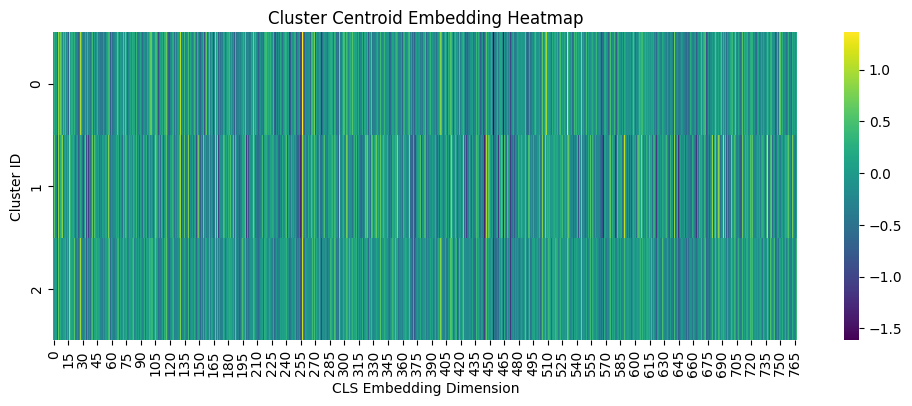

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

centroids = []
for cluster_id in np.unique(all_cluster_preds):
    cluster_embs = all_cls_embeddings[all_cluster_preds == cluster_id]
    centroid = cluster_embs.mean(axis=0)
    centroids.append(centroid)

centroids = np.array(centroids)

plt.figure(figsize=(12, 4))
sns.heatmap(centroids, cmap='viridis', cbar=True)
plt.title("Cluster Centroid Embedding Heatmap")
plt.xlabel("CLS Embedding Dimension")
plt.ylabel("Cluster ID")
plt.show()


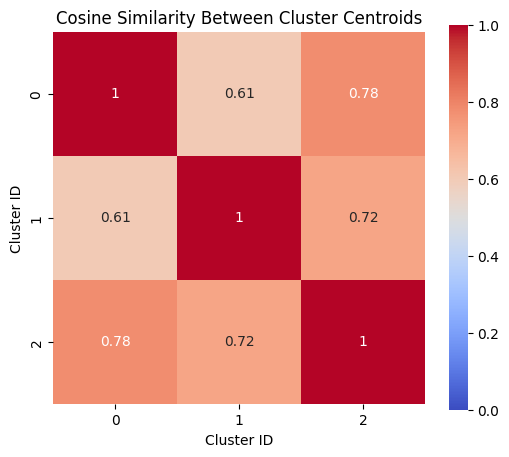

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(centroids)

plt.figure(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm', square=True, vmin=0, vmax=1)
plt.title("Cosine Similarity Between Cluster Centroids")
plt.xlabel("Cluster ID")
plt.ylabel("Cluster ID")
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_attention_by_cluster(vit_block, gate_network, image_tensor, cluster_ids, patch_size=16):

    vit_block.eval()
    vit_block.apply_gating = True

    with torch.no_grad():
        fig, axs = plt.subplots(1, len(cluster_ids), figsize=(5 * len(cluster_ids), 5))
        axs = axs if isinstance(axs, np.ndarray) else [axs]

        for i, cid in enumerate(cluster_ids):
            vit_block.cluster_ids = torch.tensor([cid])

            x = vit.patch_embed(image_tensor)
            cls_token = vit.cls_token.expand(1, -1, -1)
            x = torch.cat((cls_token, x), dim=1)
            x = x + vit.pos_embed
            x = vit.pos_drop(x)

            attn_block = vit_block(x)
            raw_attn = vit_block.gate_network.gates[cid].gate[0].weight.detach().cpu().numpy()  # or intermediate attention

            attn_map = vit_block.original_attn.attn_weights[:, :, 0, 1:].mean(1).reshape(14, 14).cpu()

            sns.heatmap(attn_map, ax=axs[i], cmap='viridis')
            axs[i].set_title(f"Cluster {cid}")
            axs[i].axis('off')

        plt.tight_layout()
        plt.show()


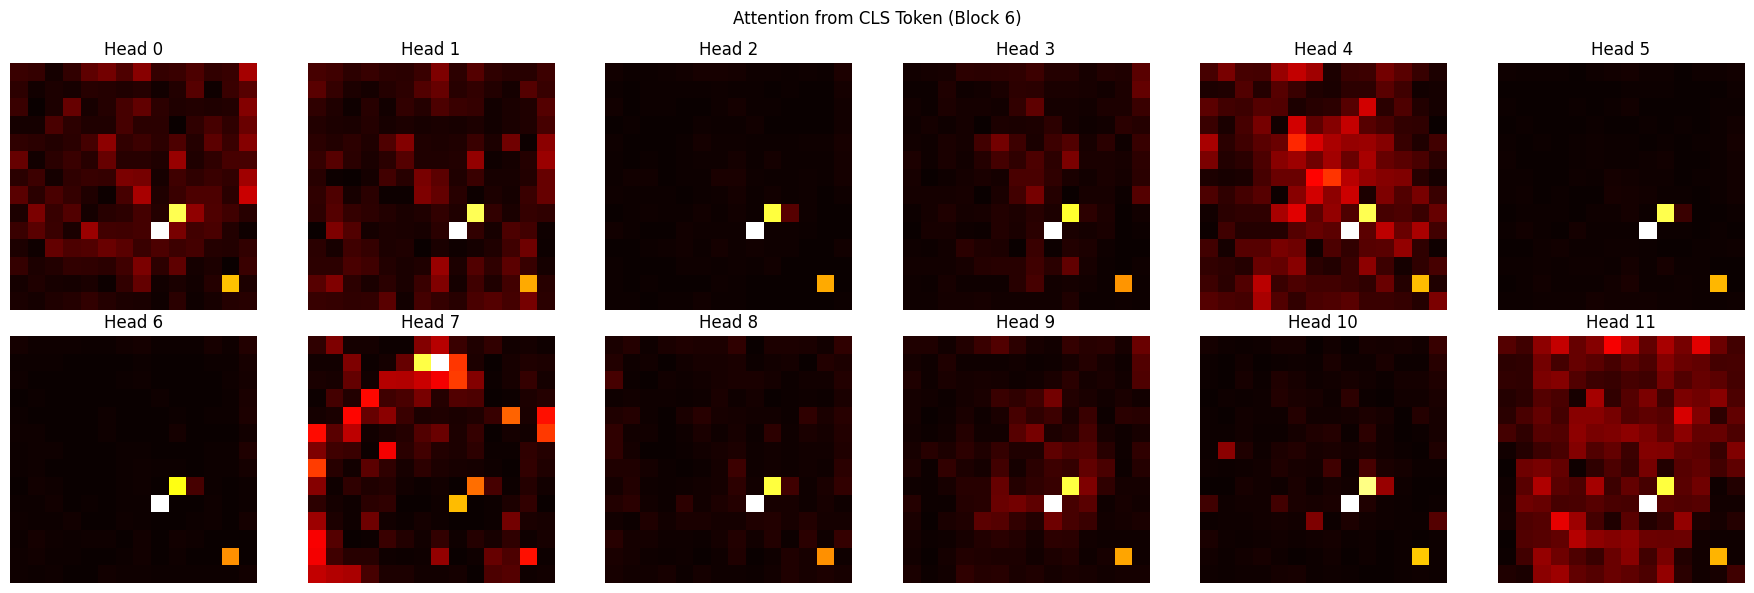

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import timm
import numpy as np
from types import MethodType

img_path = "/content/ILSVRC2012_val_00043583.JPEG"
image = Image.open(img_path).convert("RGB")

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

x = transform(image).unsqueeze(0)  # shape: [1, 3, 224, 224]

model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.eval()

def get_attention(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]
    attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)
    self.attn_weights = attn  # Save for later
    x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    return self.proj(x)

target_block = model.blocks[6]
target_block.attn.forward = MethodType(get_attention, target_block.attn)

# Forward pass
with torch.no_grad():
    _ = model(x)

attn = target_block.attn.attn_weights[0]
cls_attn = attn[:, 0, 1:]
cls_attn = cls_attn.reshape(-1, 14, 14)

fig, axs = plt.subplots(2, 6, figsize=(18, 6))
axs = axs.flatten()
for i in range(min(12, cls_attn.shape[0])):
    axs[i].imshow(cls_attn[i].cpu(), cmap='hot')
    axs[i].axis('off')
    axs[i].set_title(f"Head {i}")

plt.suptitle("Attention from CLS Token (Block 6)")
plt.tight_layout()
plt.show()


<ipython-input-33-7b4be8609498>:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.92, 1])  # adjust to fit colorbar


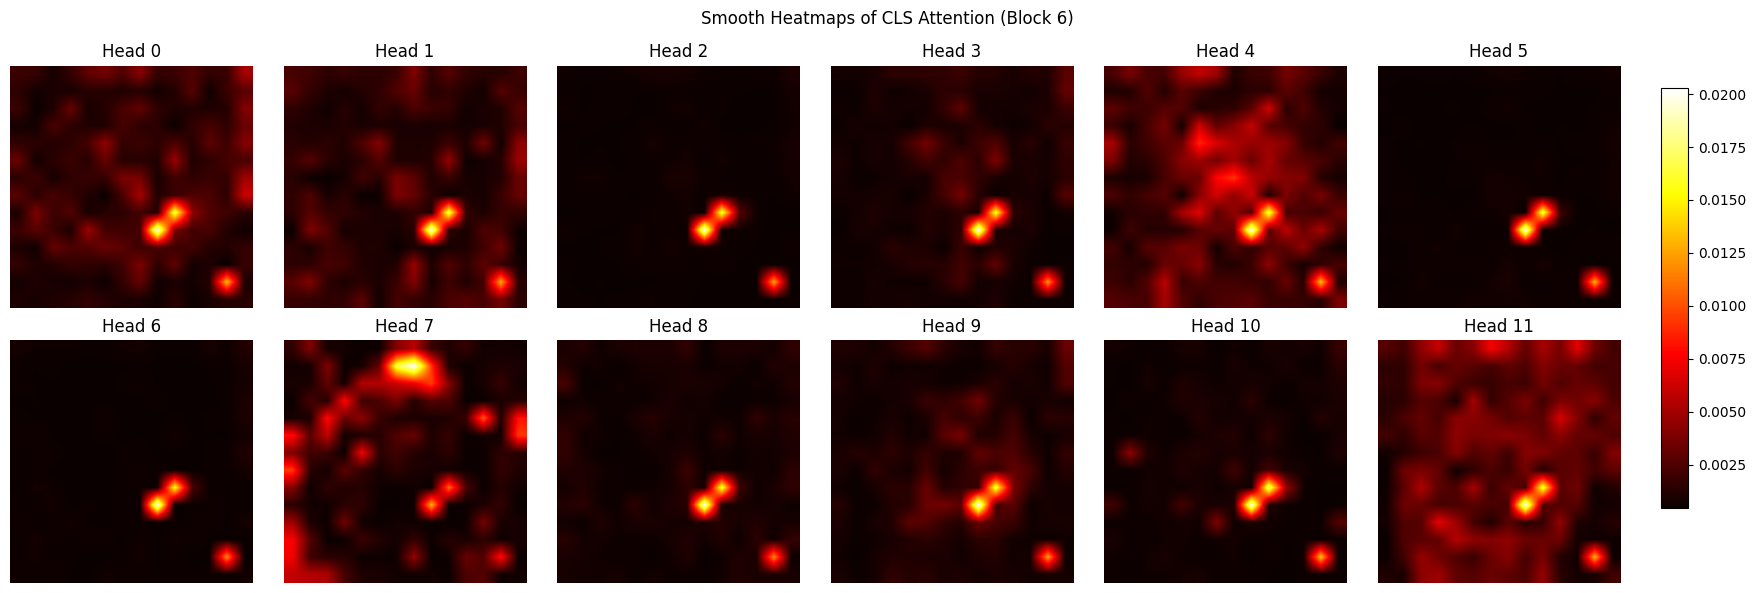

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(18, 6))
axs = axs.flatten()
for i in range(min(12, cls_attn.shape[0])):
    im = axs[i].imshow(cls_attn[i].cpu(), cmap='hot', interpolation='bilinear')  # smoother heatmap
    axs[i].axis('off')
    axs[i].set_title(f"Head {i}")

fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.suptitle("Smooth Heatmaps of CLS Attention (Block 6)")
plt.tight_layout(rect=[0, 0, 0.92, 1])
plt.show()


Device: cuda


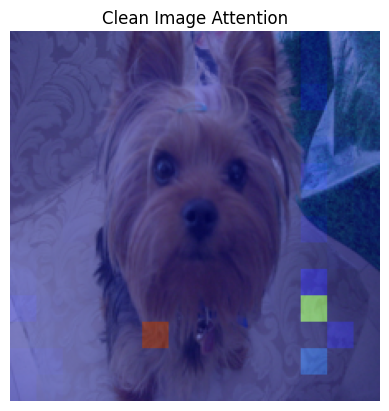

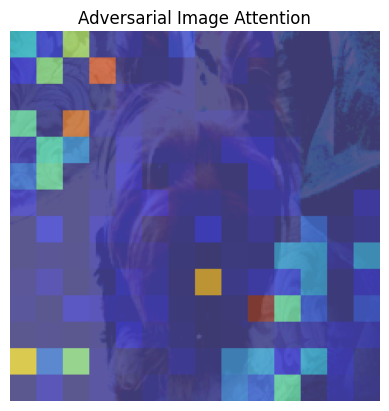

In [ ]:
!pip install timm torchattacks --quiet

import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torchattacks

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

image_path = 'ILSVRC2012_val_00043583.JPEG'  # Yorkshire Terrier

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

img_pil = Image.open(image_path).convert('RGB')
img_tensor = transform(img_pil).unsqueeze(0).to(device)

from timm.models.vision_transformer import Attention

def patch_attention(attn):
    def get_attn(self):
        B, N, C = self.input_x.shape
        qkv = self.qkv(self.input_x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        scores = (q @ k.transpose(-2, -1)) * self.scale
        return scores.softmax(dim=-1)[:, :, 0, 1:]  # CLS-to-patch only

    def forward_hook(self, x):
        self.input_x = x
        return self._original_forward(x)

    attn.get_attention_map = get_attn.__get__(attn, Attention)
    attn._original_forward = attn.forward
    attn.forward = forward_hook.__get__(attn, Attention)

model = timm.create_model('vit_base_patch16_224', pretrained=True).to(device).eval()
patch_attention(model.blocks[-1].attn)
last_attn = model.blocks[-1].attn

with torch.no_grad():
    _ = model(img_tensor)
    attn_clean = last_attn.get_attention_map()

label = torch.tensor([187]).to(device)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=10)
adv_tensor = pgd(img_tensor, label)

with torch.no_grad():
    _ = model(adv_tensor)
    attn_adv = last_attn.get_attention_map()

def unnormalize(t):
    mean = torch.tensor([0.485, 0.456, 0.406], device=t.device).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=t.device).view(1,3,1,1)
    return (t * std + mean).clamp(0, 1)

def visualize_attn_map(img_tensor, attn_map, title):
    img = unnormalize(img_tensor).squeeze().permute(1, 2, 0).cpu().numpy()
    attn = attn_map.squeeze(0).mean(0).reshape(14, 14).cpu().numpy()
    attn = (attn - attn.min()) / (attn.max() - attn.min())
    attn = np.kron(attn, np.ones((16, 16)))  # upscale to 224x224

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(attn, cmap='jet', alpha=0.5)
    ax.set_title(title)
    ax.axis('off')
    return fig

visualize_attn_map(img_tensor, attn_clean, "Clean Image Attention")
visualize_attn_map(adv_tensor, attn_adv, "Adversarial Image Attention")
plt.show()


Device: cuda


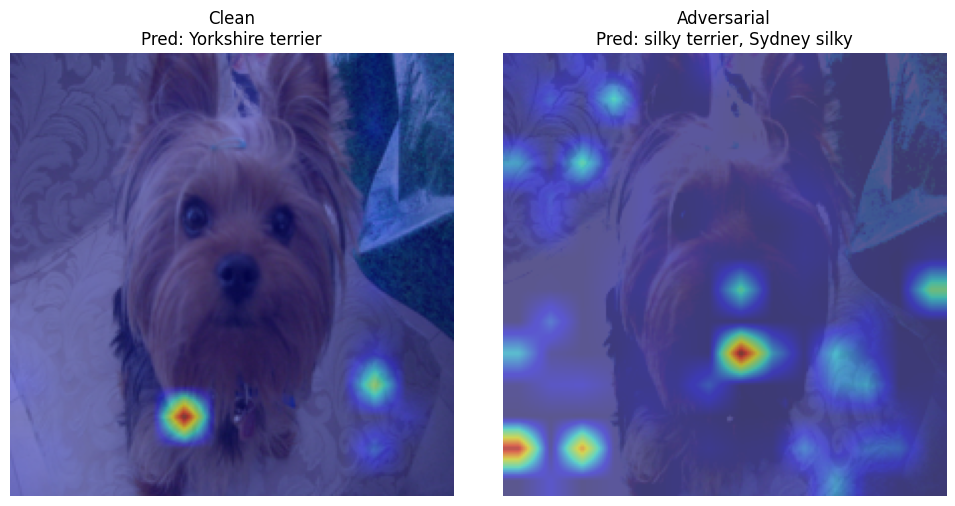

In [ ]:
def make_heatmap(attn_map):
    attn = attn_map.mean(dim=1)  # [1, 196]
    attn = attn.reshape(1, 1, 14, 14)  # [1, 1, 14, 14]
    attn = F.interpolate(attn, size=(224, 224), mode='bilinear', align_corners=False)  # smooth!
    attn = attn.squeeze().cpu().numpy()
    attn = (attn - attn.min()) / (attn.max() - attn.min())
    return attn


def show_heatmap_overlay(img_tensor, attn_map, title, label_text):
    img = unnormalize(img_tensor).squeeze().permute(1, 2, 0).cpu().numpy()
    heat = make_heatmap(attn_map)

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.imshow(heat, cmap='jet', alpha=0.5)
    ax.set_title(f"{title}\nPredicted: {label_text}")
    ax.axis('off')
    return fig


class_map_df = pd.read_csv("/content/class_map.csv")
IMAGENET_LABELS = class_map_df.set_index("id")["class_name"].to_dict()

label_clean = IMAGENET_LABELS[pred_clean] if pred_clean < len(IMAGENET_LABELS) else f"Class {pred_clean}"
label_adv = IMAGENET_LABELS[pred_adv] if pred_adv < len(IMAGENET_LABELS) else f"Class {pred_adv}"

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
img = unnormalize(img_tensor).squeeze().permute(1, 2, 0).cpu().numpy()
heat = make_heatmap(attn_clean)
plt.imshow(img)
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.title(f"Clean\nPred: {label_clean}")
plt.axis('off')

plt.subplot(1, 2, 2)
img = unnormalize(adv_tensor).squeeze().permute(1, 2, 0).cpu().numpy()
heat = make_heatmap(attn_adv)
plt.imshow(img)
plt.imshow(heat, cmap='jet', alpha=0.5)
plt.title(f"Adversarial\nPred: {label_adv}")
plt.axis('off')

plt.tight_layout()
plt.show()
